# Absenteeism

* Data Source: Udemy - Data Science Bootcamp Program 2024
* Author: Huu Phuc (Felix) Hong
* Last Update: 9 January, 2024

### Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Library for modelling and scoring performance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf

### Declare Functions

In [2]:
# Function declaration for plotting confusion matrix after modelling
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not approved', 'Approved']); ax.yaxis.set_ticklabels(['Not approved', 'Approved']) 
    plt.show() 

### Model Expected Output

The initial target column of the dataset is Absenteeism Time in Hours. However, in reality, the information about employees with excessive absence may be more appropriate. Therefore, the expected outcome of our model will be changed to test if an employee has the intention to be excessively absent or not (1 for excessive absence, 0 otherwise)

In [3]:
# Read data
df = pd.read_csv("Absenteeism_preprocessed.csv")

In [4]:
# Find median of target column, if Absenteeism Time in Hours of an employee is
# higher than median of the whole sample, then we will treat it as excessive absence
# 1 for excessive absence, 0 otherwise
df['Excessive Absenteeism'] = np.where(df['Absenteeism Time in Hours']
                                       > df['Absenteeism Time in Hours'].median(), 1, 0)

In [5]:
# Drop Absenteeism Time in Hours column after transforming target
df.drop(['Absenteeism Time in Hours'], axis=1, inplace=True)

We see that 45.6% of the employees in the dataset are excessively absent. Therefore, the data is quite balance and appropriate for modelling.

In [6]:
# Test to ensure the data target is balance
df['Excessive Absenteeism'].sum()/len(df['Excessive Absenteeism'])

0.45571428571428574

### Modelling

In [7]:
# Declare dependent & independent variables
X = df.drop(['Excessive Absenteeism'], axis=1)
y = df['Excessive Absenteeism']

In [8]:
# Build CustomScaler based on StandardScaler for scale chosen columns only

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

# create the Custom Scaler class

class CustomScaler(BaseEstimator,TransformerMixin): 
    
    # init or what information we need to declare a CustomScaler object
    # and what is calculated/declared as we do
    
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        
        # scaler is nothing but a Standard Scaler object
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std
        self.scaler = StandardScaler(copy=copy,with_mean=with_mean,with_std=with_std)
        # with some columns 'twist'
        self.columns = columns
        self.mean_ = None
        self.var_ = None
        
    
    # the fit method, which, again based on StandardScale
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        
        # record the initial order of the columns
        init_col_order = X.columns
        
        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        
        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        
        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return np.array(pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order])

In [9]:
# We need to make custom scaler because we want to exclude created dummy variables
# so that we can interpret the results of the model
columns_to_omit = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4','Education']

In [10]:
# Defind columns to scale
columns_to_scale = [x for x in X.columns.values if x not in columns_to_omit]

In [11]:
# Scaling
absenteeism_scaler = CustomScaler(columns_to_scale)
absenteeism_scaler.fit(X)
X = absenteeism_scaler.transform(X)

/Users/honghuuphuc/anaconda3/envs/myenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [12]:
# Split data into train-test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Logistic Regression

In [13]:
# Create parameters for GridSearchCV
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}

# Create the LogisticRegression
lr=LogisticRegression()

# Create the GridSearchCV
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit GridSearchCV to find the best hyperparameters
logreg_cv.fit(X_train, y_train)
print("Best parameters: ", logreg_cv.best_params_)

# Cross validation for avoiding overfitting
cross_val_scores = cross_val_score(logreg_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cross_val_scores)

# Predict target of test set
yhat=logreg_cv.predict(X_test)

Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-Validation Scores: [0.79464286 0.76785714 0.70535714 0.69642857 0.71428571]


In [14]:
accuracy_lr_cv = accuracy_score(y_test, yhat)

In [15]:
confusion_matrix(y_test, yhat)

array([[67, 15],
       [16, 42]])

In [16]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        82
           1       0.74      0.72      0.73        58

    accuracy                           0.78       140
   macro avg       0.77      0.77      0.77       140
weighted avg       0.78      0.78      0.78       140



#### K-Nearest Neighbors

In [17]:
# Create parameters for GridSearchCV
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

# Create the KNeighborsClassifier
knn = KNeighborsClassifier()

# Create GridSearchCV
knn_cv = GridSearchCV(estimator=knn, param_grid=parameters, cv=5, error_score='raise')

# Fit GridSearchCV to find the best hyperparameters
knn_cv.fit(X_train, y_train)
print("Best parameters: ", knn_cv.best_params_)

# Cross validation for avoiding overfitting
cross_val_scores = cross_val_score(knn_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cross_val_scores)

# Predict target of test set
yhat=knn_cv.predict(X_test)

Best parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}
Cross-Validation Scores: [0.70535714 0.73214286 0.65178571 0.6875     0.69642857]


In [18]:
accuracy_knn_cv = accuracy_score(y_test, yhat)

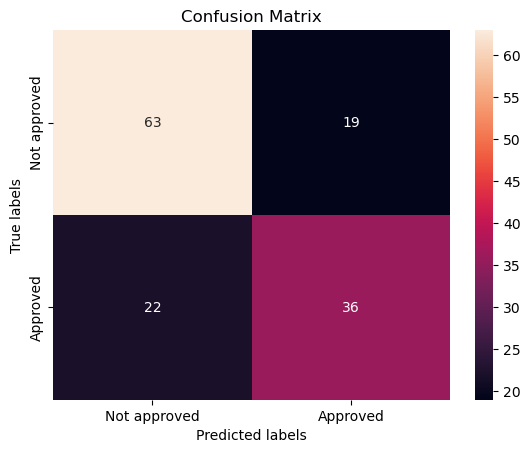

In [19]:
plot_confusion_matrix(y_test, yhat)

In [20]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75        82
           1       0.65      0.62      0.64        58

    accuracy                           0.71       140
   macro avg       0.70      0.69      0.70       140
weighted avg       0.71      0.71      0.71       140



#### Random Forest

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [22]:
# Create parameters for GridSearchCV
parameters = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2']
}

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state = 42, class_weight = 'balanced')

# Create GridSearchCV
rf_classifier_cv = GridSearchCV(estimator=rf_classifier, param_grid=parameters, cv=5, error_score='raise', scoring='accuracy')

# Fit the GridSearchCV to find the best hyperparameters
rf_classifier_cv.fit(X_train, y_train)
print("Best parameters: ", rf_classifier_cv.best_params_)

# Cross validation for avoiding overfitting
cross_val_scores = cross_val_score(rf_classifier_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cross_val_scores)

# Predict target in test data 
yhat=rf_classifier_cv.predict(X_test)

Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Cross-Validation Scores: [0.75       0.83035714 0.76785714 0.74107143 0.76785714]


In [23]:
accuracy_rf_cv = accuracy_score(y_test, yhat)

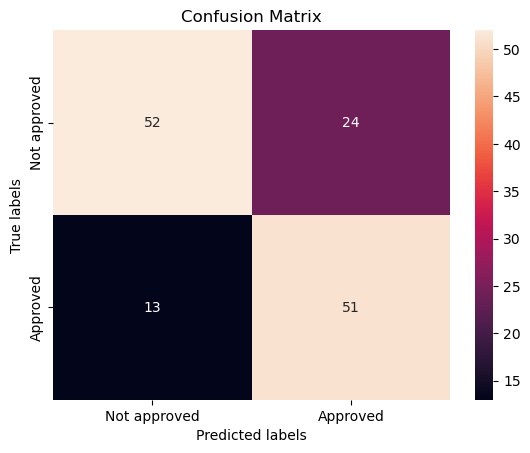

In [24]:
plot_confusion_matrix(y_test, yhat)

In [25]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74        76
           1       0.68      0.80      0.73        64

    accuracy                           0.74       140
   macro avg       0.74      0.74      0.74       140
weighted avg       0.75      0.74      0.74       140



#### Support Vector Machine

In [26]:
# Define the parameter grid for the SVM
svm_parameters = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Create the SVM classifier
svm_classifier = SVC(random_state=42, class_weight='balanced')

# Create GridSearchCV for SVM with cross-validation
svm_cv = GridSearchCV(estimator=svm_classifier, param_grid=svm_parameters, cv=5, error_score='raise', scoring='accuracy')

# Fit the GridSearchCV to find the best hyperparameters for SVM
svm_cv.fit(X_train, y_train)
print("Best parameters for SVM: ", svm_cv.best_params_)

# Cross-validation scores
cross_val_scores_svm = cross_val_score(svm_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores for SVM:", cross_val_scores_svm)

# Predict target in test data using the SVM classifier with best parameters
yhat = svm_cv.best_estimator_.predict(X_test)

Best parameters for SVM:  {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Cross-Validation Scores for SVM: [0.73214286 0.76785714 0.72321429 0.75892857 0.74107143]


In [27]:
accuracy_svm_cv = accuracy_score(y_test, yhat)

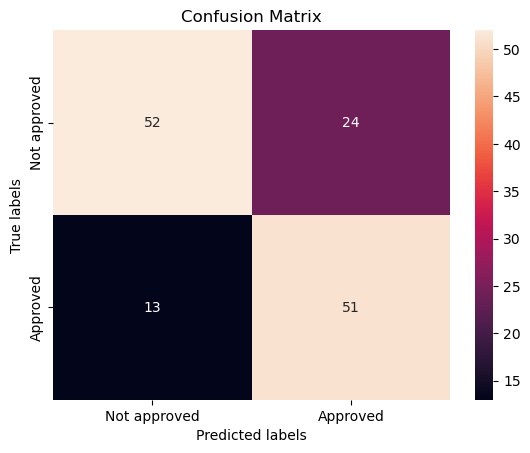

In [28]:
plot_confusion_matrix(y_test, yhat)

In [29]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74        76
           1       0.68      0.80      0.73        64

    accuracy                           0.74       140
   macro avg       0.74      0.74      0.74       140
weighted avg       0.75      0.74      0.74       140



#### TensorFlow

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [31]:
# Split 10% of X_train and y_train for validation
X_train, validation_inputs, y_train, validation_targets = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [32]:
tf.config.experimental.set_visible_devices([], 'GPU')
# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
# note that this time the train, validation and test data are not iterable
model.fit(X_train, # train inputs
          y_train, # train targets
          batch_size=batch_size, # batch size
          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
          # callbacks are functions called by a task when a task is completed
          # task here is to check if val_loss is increasing
          callbacks=[early_stopping], # early stopping
          validation_data=(validation_inputs, validation_targets), # validation data
          verbose = 2 # making sure we get enough information about the training process
          )  

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/100
6/6 - 0s - loss: 0.6854 - accuracy: 0.5838 - val_loss: 0.6717 - val_accuracy: 0.6508 - 496ms/epoch - 83ms/step
Epoch 2/100
6/6 - 0s - loss: 0.6569 - accuracy: 0.6737 - val_loss: 0.6581 - val_accuracy: 0.6508 - 20ms/epoch - 3ms/step
Epoch 3/100
6/6 - 0s - loss: 0.6320 - accuracy: 0.6861 - val_loss: 0.6470 - val_accuracy: 0.7143 - 18ms/epoch - 3ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6091 - accuracy: 0.7037 - val_loss: 0.6431 - val_accuracy: 0.6190 - 17ms/epoch - 3ms/step
Epoch 5/100
6/6 - 0s - loss: 0.5833 - accuracy: 0.7390 - val_loss: 0.6288 - val_accuracy: 0.6508 - 16ms/epoch - 3ms/step
Epoch 6/100
6/6 - 0s - loss: 0.5559 - accuracy: 0.7637 - val_loss: 0.6173 - val_accuracy: 0.6508 - 17ms/epoch - 3ms/step
Epoch 7/100
6/6 - 0s - loss: 0.5304 - accuracy: 0.7795 - val_loss: 0.6215 - val_accuracy: 0.6508 - 17ms/epoch - 3ms/step
Epoch 8/100
6/6 - 0s - loss: 0.5059 - accuracy: 0.7866 - val_loss: 0.6313 - val_accuracy: 0.6349 - 17ms/epoch - 3ms/step
3/3 [=========================

In [34]:
accuracy_tf = test_accuracy

In [40]:
report = pd.DataFrame({"Model":["RF Classifier", "LR", "KNN", "SVM", "TensorFlow"],
                       "Accuracy (%)": [round(accuracy_rf_cv,2), round(accuracy_lr_cv,2), 
                                        round(accuracy_knn_cv,2), round(accuracy_svm_cv,2),
                                        round(accuracy_tf,2)]})
report["Accuracy (%)"] = report["Accuracy (%)"]*100
report.sort_values(["Accuracy (%)"], ascending=False)

,Model,Accuracy (%)
1,LR,78.0
0,RF Classifier,74.0
3,SVM,74.0
4,TensorFlow,73.0
2,KNN,71.0


## From the report above, logistic regression will be the best fit model for predicting absenteeism based on our dataset